In [2]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Interactive plots
%matplotlib notebook

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import scipy.signal
import mypackage
import os

plt.style.use('ggplot')

TensorFlow version is 2.1.0


In [5]:
file_names = ['20200213_113826_fillet_sample30', '20200213_113854_fillet_sample31', '20200213_113925_fillet_sample32', '20200213_113949_fillet_sample33', '20200213_114007_fillet_sample34', '20200213_114025_fillet_sample35', '20200213_114052_fillet_sample36', '20200213_114111_fillet_sample37', '20200213_114129_fillet_sample38', '20200213_114148_fillet_sample39']

X, Y, info = mypackage.Dataset.load_files(file_names, '../data/tomra')
wavelengths = [928, 932, 935, 939, 942, 946, 950, 953, 957, 960, 964, 968, 971, 975, 978, 982, 986, 989, 993, 997, 1000, 1004, 1007, 1011, 1015, 1018, 1022, 1025, 1029, 1033, 1036, 1040, 1043, 1047, 1051, 1054, 1058, 1061, 1065, 1069, 1072, 1076, 1079, 1083, 1087, 1090, 1094, 1097, 1101, 1105, 1108, 1112, 1115, 1119, 1123, 1126, 1130, 1134, 1137, 1141, 1144, 1148, 1152, 1155, 1159, 1162, 1166, 1170, 1173, 1177, 1180, 1184, 1188, 1191, 1195, 1198, 1202, 1206, 1209, 1213, 1216, 1220, 1224, 1227, 1231, 1234, 1238, 1242, 1245, 1249, 1252, 1256, 1260, 1263, 1267, 1271, 1274, 1278, 1281, 1285, 1289, 1292, 1296, 1299, 1303, 1307, 1310, 1314, 1317, 1321, 1325, 1328, 1332, 1335, 1339, 1343, 1346, 1350, 1353, 1357, 1361, 1364, 1368, 1371, 1375, 1379, 1382, 1386, 1390, 1393, 1397, 1400, 1404, 1408, 1411, 1415, 1418, 1422, 1426, 1429, 1433, 1436, 1440, 1444, 1447, 1451, 1454, 1458, 1462, 1465, 1469, 1472, 1476, 1480, 1483, 1487, 1490, 1494, 1498, 1501, 1505, 1508, 1512, 1516, 1519, 1523, 1527, 1530, 1534, 1537, 1541, 1545, 1548, 1552, 1555, 1559, 1563, 1566, 1570, 1573, 1577, 1581, 1584, 1588, 1591, 1595, 1599, 1602, 1606, 1609, 1613, 1617, 1620, 1624, 1627, 1631, 1635, 1638, 1642, 1645, 1649, 1653, 1656, 1660, 1664, 1667, 1671, 1674]

# _, X = mypackage.Dataset.scale(X_test=None, X_train=X, scale='GlobalStandardization')

The main image used for dimension reduction training is "20200213_114148_fillet_sample39" a.k.a. "20200213_114148_LayerFM_39_ReflectionPoints.jpg"
![LayerFM_39_ReflectionPoints](20200213_114148_LayerFM_39_ReflectionPoints.jpg)
![LayerFM_39_ReflectionPoints_Flipped](20200213_114148_LayerFM_39_ReflectionPoints_Flipped.jpg)

<IPython.core.display.Javascript object>


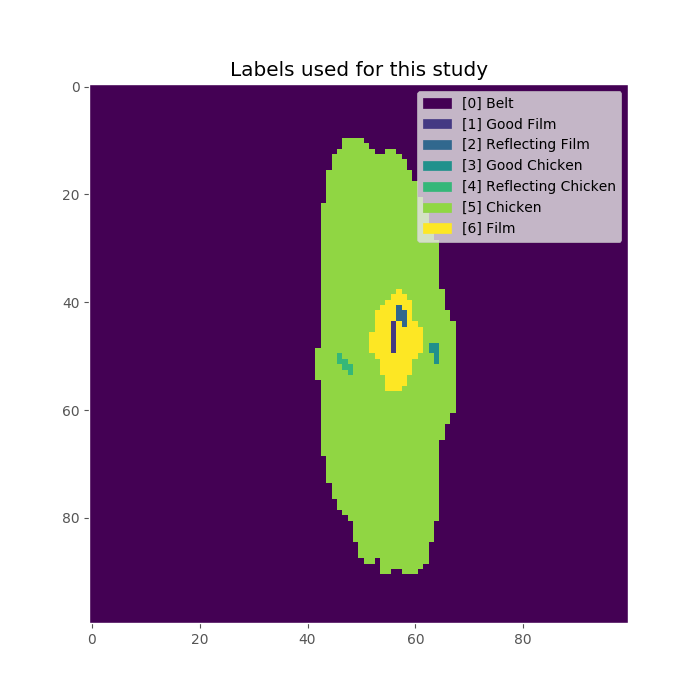

<IPython.core.display.Javascript object>


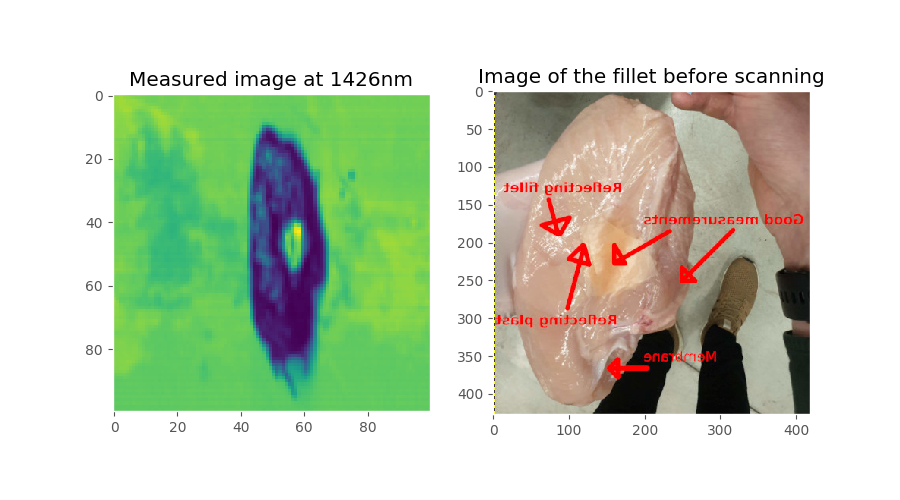

In [51]:
# Read in the selective labeled image
#     Bakground = White = FFFF = 65535
#     Plastic film       = 1     -> 6 pixles
#     Reflecting film    = 2     -> 6 pixles
#     Chicken fillet     = 3     -> 6 pixles
#     Reflecting chicken = 4     -> 6 pixles
#        The chicken rest = 640000 => 5
#        The plastic rest = 006400 => 6
#     Chicken membrane was not visible for labeling
file_label = np.squeeze(mypackage.Dataset.read_image('20200213_114148_fillet_sample39_out.png', channel_index_last=False))
labels = {}
for idx, item in enumerate(['Belt', 'Good Film', 'Reflecting Film', 'Good Chicken', 'Reflecting Chicken', 'Chicken', 'Film']):
    labels[item] = idx

plt.figure(figsize=(7,7))
plt.title("Labels used for this study")
img = plt.imshow(file_label)
mypackage.Dataset._Dataset__add_legend_to_image(file_label, img, legend=labels.keys())
plt.grid(False)
plt.show()

file_idx = file_names.index('20200213_114148_fillet_sample39')
water_absorption_idx = wavelengths.index(1426)

plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title(f"Measured image at {wavelengths[water_absorption_idx]}nm")
plt.imshow(X[file_idx, :, :, water_absorption_idx])
plt.grid(False)

import matplotlib.image as mpimg
img=mpimg.imread('20200213_114148_LayerFM_39_ReflectionPoints_Flipped.jpg')
plt.subplot(1, 2, 2)
plt.title("Image of the fillet before scanning")
imgplot = plt.imshow(img)
plt.grid(False)
plt.show()

In [52]:
labels

{'Belt': 0,
 'Good Film': 1,
 'Reflecting Film': 2,
 'Good Chicken': 3,
 'Reflecting Chicken': 4,
 'Chicken': 5,
 'Film': 6}

In [53]:
labels.keys()

dict_keys(['Belt', 'Good Film', 'Reflecting Film', 'Good Chicken', 'Reflecting Chicken', 'Chicken', 'Film'])

In [57]:
# wavelength_columns = [f"{i}nm" for i in wavelengths]
columns = ['Good Film', 'Reflecting Film', 'Good Chicken', 'Reflecting Chicken']

file_data = X[file_idx]
# df = pd.DataFrame(columns=columns)

# def add_data_to_df(df, data, info):
#     n = len(data)
#     df = df.append(pd.DataFrame(data=np.column_stack(([info]*n, data)), columns=columns), ignore_index=True)
#     return df

# df = add_data_to_df(df, just_meat, numb_layers=0)

# for col in columns:
#     spectal_pixels = file_data[file_label == labels[col], :] # X[i, np.squeeze(Y[i] == 2), :]
    
#     df = add_data_to_df(df, spectal_pixels, numb_layers=col)

# pd.DataFrame(data=np.column_stack([file_data[file_label == labels[col]] for col in columns]), columns=columns))
np.array([file_data[file_label == labels[col]] for col in columns]).shape

(4, 6, 208)

<IPython.core.display.Javascript object>


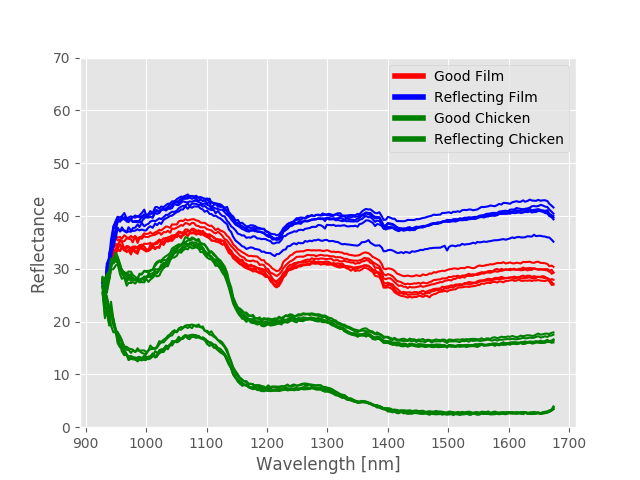

In [64]:
def add_all_pixels_to_plot(data, color):
    to_plot = np.reshape(data, (-1, 208))
    n, m = to_plot.shape
    for i in range(n):
        plt.plot(wavelengths, to_plot[i, :], color)

fig = plt.figure()
add_all_pixels_to_plot(file_data[file_label == labels['Good Film']], color='r') 
add_all_pixels_to_plot(file_data[file_label == labels['Reflecting Film']], color='b')
add_all_pixels_to_plot(file_data[file_label == labels['Good Chicken']], color='g')
add_all_pixels_to_plot(file_data[file_label == labels['Reflecting Chicken']], color='g')
plt.ylim(0, 70)
plt.ylabel("Reflectance")
plt.xlabel("Wavelength [nm]")

ax = fig.axes[0]
ax.legend([Line2D([0], [0], color='Red', lw=4),
           Line2D([0], [0], color='Blue', lw=4),
           Line2D([0], [0], color='Green', lw=4),
           Line2D([0], [0], color='Green', lw=4)], ['Good Film', 'Reflecting Film',
                                                    'Good Chicken', 'Reflecting Chicken']);

In [ ]:
# # https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
# arrays = [np.array(),
#           np.array(wavelengths*n_samples)]
# pd.DataFrame(np.random.randn(8, 4), index=arrays)

The expected correlation between reflecting material is not visible in the plot here above. Thus an attempt to figure out the expected number of classes in this dataset based on PCA.

In [ ]:
# This is stuff from: http://127.0.0.1:8888/notebooks/Code/Scripts/SpectralDimensionReduction.ipynb
# With scaling
X_train, X_test, Y_train, Y_test = load_data()

_, X_pca = mypackage.Dataset.PCA(X_train[:, :, :, 10:-10], X_test[:, :, :, 10:-10], n_components=3, plot=True)

n_items, n, m, k = X_pca.shape
df = pd.DataFrame(X_pca.reshape((n_items*n*m, k)), columns=['PCA_1', 'PCA_2', 'PCA_3'])
df['Labels'] = Y_test.reshape((n_items*n*m, 1)).copy()
items = ['Belt', 'Meat', 'Contaminant 1', 'Contaminant 2', 'Contaminant 3', 'Contaminant 4']
for i, item in enumerate(items):
    df['Labels'][df['Labels'] == i+1] = item
sns.pairplot(df, hue='Labels', height=3)
plt.show()